# Understanding Gaussian processes

This post explores some of the concepts behind Gaussian processes such as stochastic processes and the kernel function. We will build up deeper understanding on how to implement Gaussian process regression from scratch on a toy example.

This post is followed by a second post demonstrating how to fit a Gaussian process kernel with [TensorFlow probability](https://www.tensorflow.org/probability/). This post is part of series on Gaussian processes:

1. [Understanding Gaussian processes (this)](https://peterroelants.github.io/posts/gaussian-process-tutorial/)
2. Fitting a Gaussian process kernel
3. Gaussian process kernels

In what follows we assume familiarity with basic probability and linear algebra especially in the context of multivariate Gaussian distributions. Have a look at [this post]({% post_url 2018-09-28-multivariate-normal-primer %}) if you need a refresher on the Gaussian distribution.

In [2]:
# Imports
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

What are Gaussian processes? The name implies that its a stochastic process of random variables with a Gaussian distribution. This might not mean much at this moment so lets dig a bit deeper in its meaning.


## Stochastic process

[Stochastic processes](https://en.wikipedia.org/wiki/Stochastic_process) typically describe systems randomly changing over time. The processes are [stochastic](https://en.wikipedia.org/wiki/Stochastic) due to the uncertainty in the system. Even if the starting point is known, there are several directions in which the processes can evolve.

An example of a stochastic process that you might have come across is the model of [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion) (also known as [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) ). Brownian motion is the random motion of particles suspended in a fluid. It can be seen as a continuous [random walk](https://en.wikipedia.org/wiki/Random_walk) where a particle moves around in the fluid due to other particles randomly bumping into it. We can simulate this process over time $t$ in 1 dimension $d$ by starting out at position 0 and move the particle over a certain amount of time $\Delta t$ with a random distance $\Delta d$ from the previous position.The random distance is sampled from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with mean $0$ and variance $\Delta t$. Sampling $\Delta d$ from this normal distribution is noted as $\Delta d \sim \mathcal{N}(0, \Delta t)$. The position $d(t)$ at time $t$ evolves as $d(t + \Delta t) = d(t) + \Delta d$.

We simulate 5 different paths of brownian motion in the following figure, each path is illustrated with a different color.

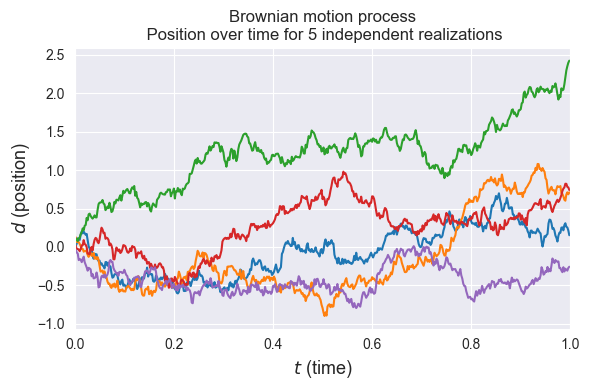

In [3]:
# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 500
delta_t = total_time / nb_steps
nb_processes = 5  # Simulate 5 different motions
mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively
#  making a new movement delta_d
distances = np.cumsum(
    # Move randomly from current location to N(0, delta_t)
    np.random.normal(
        mean, stdev, (nb_processes, nb_steps)),
    axis=1)

plt.figure(figsize=(6, 4), dpi=100)
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])
plt.title((
    'Brownian motion process\n '
    'Position over time for 5 independent realizations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.xlim([-0, 1])
plt.tight_layout()
plt.show()
#

### Stochastic processes as distributions over functions

Notice in the figure above that the stochastic process can lead to different paths, also known as [realizations](https://en.wikipedia.org/wiki/Realization_%28probability%29) of the process.  Each realization defines a position $d$ for every possible timestep $t$. Every realization thus corresponds to a function $f(t) = d$.

This means that a stochastic process can be interpreted as a random distribution over functions. We can sample a realization of a function from a stochastic process. However each realized function can be different due to the randomness of the stochastic process.

Like the model of Brownian motion, Gaussian processes are stochastic processes. In fact, the Brownian motion process can be reformulated as a Gaussian process[⁽³⁾](#References).

## Gaussian processes

Gaussian processes are distributions over functions $f(x)$ of which the distribution is defined by a mean function $m(x)$ and [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix) covariance function $k(x,x')$, with $x$ the function values and $(x,x')$ all possible pairs in the input [domain](https://en.wikipedia.org/wiki/Domain_of_a_function):

$$f(x) \sim \mathcal{GP}(m(x),k(x,x'))$$

where for any finite subset $X =\{\mathbf{x}_1 \ldots \mathbf{x}_n \}$ of the domain of $x$, the [marginal distribution](https://en.wikipedia.org/wiki/Marginal_distribution) is a [multivariate Gaussian]({% post_url 2018-09-28-multivariate-normal-primer %}) distribution:

$$f(X) \sim \mathcal{N}(m(X), k(X, X))$$

with mean vector $\mathbf{\mu} = m(X)$ and covariance matrix $\Sigma = k(X, X)$.

While the multivariate Gaussian caputures a finite number of jointly distributed Gaussians, the Gaussian process doesn't have this limitation. Its mean and covariance are defined by a [function](https://en.wikipedia.org/wiki/Function_(mathematics)). Each input to this function is a variable correlated with the other variables in the input domain, as defined by the covariance function. Since functions can have an infinite input domain, the Gaussian process can be interpreted as an infinite dimensional Gaussian random variable.

### Covariance function as prior

To sample functions from the Gaussian process we need to define the mean and covariance functions. The [covariance function](https://en.wikipedia.org/wiki/Covariance_function) $k(x_a, x_b)$ models the joint variability of the Gaussian process random variables. It returns the modelled [covariance](https://en.wikipedia.org/wiki/Covariance) between each pair in $x_a$ and $x_b$.

The specification of this covariance function, also known as the kernel function, implies a distribution over functions $f(x)$. By choosing a specific kernel function $k$ it is possible to set [prior](https://en.wikipedia.org/wiki/Prior_probability) information on this distribution. This kernel function needs to be [positive-definite](https://en.wikipedia.org/wiki/Positive-definite_function) in order to be a valid covariance function.

In this post we will model the covariance with the [exponentiated quadratic ](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) covariance function (also known as the RBF kernel):

$$k(x_a, x_b) = \exp{ \left( -\frac{1}{2\sigma^2} \lVert x_a - x_b \rVert^2 \right)}$$

Other kernel function can be defined resulting in different priors on the Gaussian process distribution. Examples of different kernels are given in a [follow up post]({% post_url 2019-01-05-gaussian-process-kernels %}).

In [4]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

An example covariance matrix from the exponentiated quadratic  covariance function is plotted in the figure below on the left. The covariance vs input zero is plotted on the right. Note that the exponentiated quadratic covariance decreases exponentially the further away the function values $x$ are from eachother.

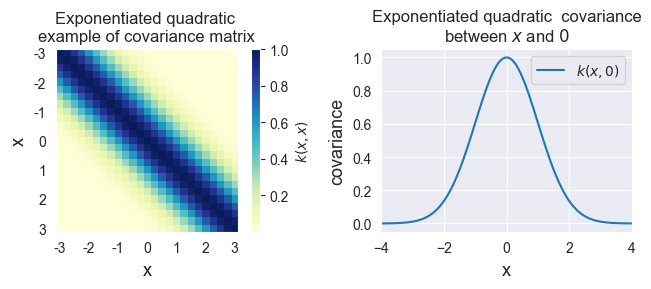

In [5]:
# Illustrate covariance matrix and function

# Show covariance matrix example from exponentiated quadratic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=100)
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, 25), 1)
Σ = exponentiated_quadratic(X, X)
# Plot covariance matrix
im = ax1.imshow(Σ, cmap=cm.YlGnBu)
cbar = plt.colorbar(
    im, ax=ax1, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
ax1.set_title((
    'Exponentiated quadratic \n'
    'example of covariance matrix'))
ax1.set_xlabel('x', fontsize=13)
ax1.set_ylabel('x', fontsize=13)
ticks = list(range(xlim[0], xlim[1]+1))
ax1.set_xticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_yticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_xticklabels(ticks)
ax1.set_yticklabels(ticks)
ax1.grid(False)

# Show covariance with X=0
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
zero = np.array([[0]])
Σ0 = exponentiated_quadratic(X, zero)
# Make the plots
ax2.plot(X[:,0], Σ0[:,0], label='$k(x,0)$')
ax2.set_xlabel('x', fontsize=13)
ax2.set_ylabel('covariance', fontsize=13)
ax2.set_title((
    'Exponentiated quadratic  covariance\n'
    'between $x$ and $0$'))
# ax2.set_ylim([0, 1.1])
ax2.set_xlim(*xlim)
ax2.legend(loc=1)

fig.tight_layout()
plt.show()
#

### Sampling from prior

In practice we can't just sample a full function evaluation $f$ from a Gaussian process distribution since that would mean evaluating $m(x)$ and $k(x,x')$ at an infinite number of points since $x$ can have an infinite [domain](https://en.wikipedia.org/wiki/Domain_of_a_function). We can however sample function evaluations $\mathbf{y}$ of a function $f$ drawn from a Gaussian process at a finite, but arbitrary, set of points $X$, $\mathbf{y} = f(X)$.

A finite dimensional subset of the Gaussian process distribution results in a [marginal distribution](https://en.wikipedia.org/wiki/Marginal_distribution) that is a Gaussian distribution $\mathbf{y} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$ with mean vector $\mathbf{\mu} = m(X)$, covariance matrix $\Sigma = k(X, X)$. 

In the figure below we will sample 5 different function realisations from a Gaussian process with exponentiated quadratic prior[⁽¹⁾](#Sidenotes) without any observed data. We do this by drawing correlated samples from a 41-dimensional Gaussian $\mathcal{N}(0, k(X, X))$ with $X = [X_1, \ldots, X_{41}]$.

In [6]:
# Sample from the Gaussian process distribution
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

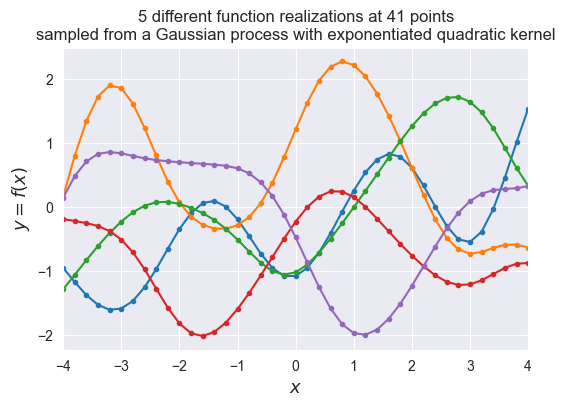

In [7]:
# Plot the sampled functions
plt.figure(figsize=(6, 4), dpi=100)
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-4, 4])
plt.show()
#

Another way to visualise this is to take only 2 dimensions of this 41-dimensional Gaussian and plot some of it's 2D marginal distibutions.

The next figure on the left visualizes the 2D distribution for $X = [0, 0.2]$ where the covariance $k(0, 0.2) = 0.98$. The figure on the right visualizes the 2D distribution for $X = [0, 2]$ where the covariance $k(0, 2) = 0.14$.

For each of the 2D Gaussian marginals the corresponding samples from the function realisations above have plotted as colored dots on the figure.

Observe that points close together in the input domain of $x$ are strongly correlated ($y_1$ is close to $y_2$), while points further away from eachother are almost independent. This is because these marginals come from a Gaussian process with as prior the exponentiated quadratic covariance which adds prior information that points close to eachother in the input space $X$ must be close to eachother in the output space $y$.

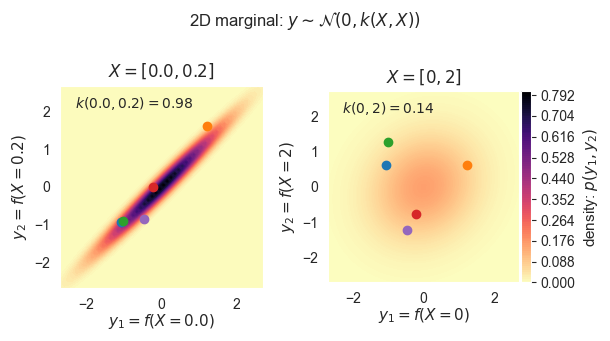

In [8]:
# Show marginal 2D Gaussians

def generate_surface(mean, covariance):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = scipy.stats.multivariate_normal.pdf(
                np.array([x1[i,j], x2[i,j]]), 
                mean=mean, cov=covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

fig = plt.figure(figsize=(6.2, 3.5), dpi=100) 
gs = gridspec.GridSpec(1, 2)
ax_p1 = plt.subplot(gs[0,0])
ax_p2 = plt.subplot(gs[0,1], sharex=ax_p1, sharey=ax_p1)

# Plot of strong correlation
X_strong = np.array([[0], [0.2]])
μ = np.array([0., 0.])
Σ_strong = exponentiated_quadratic(X_strong, X_strong)
y1, y2, p = generate_surface(μ, Σ_strong)
# Plot bivariate distribution
con1 = ax_p1.contourf(y1, y2, p, 100, cmap=cm.magma_r)
ax_p1.set_xlabel(
    f'$y_1 = f(X={X_strong[0,0]})$', 
    fontsize=11, labelpad=0)
ax_p1.set_ylabel(
    f'$y_2 = f(X={X_strong[1,0]})$', 
    fontsize=11)
ax_p1.axis([-2.7, 2.7, -2.7, 2.7])
ax_p1.set_aspect('equal')
ax_p1.text(
    -2.3, 2.1, 
    (f'$k({X_strong[0,0]}, {X_strong[1,0]}) '
     f'= {Σ_strong[0,1]:.2f}$'), 
    fontsize=10)
ax_p1.set_title(
    f'$X = [{X_strong[0,0]}, {X_strong[1,0]}]$ ', 
    fontsize=12)
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_02_index = np.where(np.isclose(X, 0.2))
y_strong = ys[:,[X_0_index[0][0], X_02_index[0][0]]]
# Show samples on surface
for i in range(y_strong.shape[0]):
    ax_p1.plot(y_strong[i,0], y_strong[i,1], marker='o')

# Plot weak correlation
X_weak = np.array([[0], [2]])
μ = np.array([0., 0.])
Σ_weak = exponentiated_quadratic(X_weak, X_weak)
y1, y2, p = generate_surface(μ, Σ_weak)
# Plot bivariate distribution
con2 = ax_p2.contourf(y1, y2, p, 100, cmap=cm.magma_r)
con2.set_cmap(con1.get_cmap())
con2.set_clim(con1.get_clim())
ax_p2.set_xlabel(
    f'$y_1 = f(X={X_weak[0,0]})$', 
    fontsize=11, labelpad=0)
ax_p2.set_ylabel(
    f'$y_2 = f(X={X_weak[1,0]})$', 
    fontsize=11)
ax_p2.set_aspect('equal')
ax_p2.text(
    -2.3, 2.1, 
    (f'$k({X_weak[0,0]}, {X_weak[1,0]}) '
     f'= {Σ_weak[0,1]:.2f}$'), 
    fontsize=10)
ax_p2.set_title(
    f'$X = [{X_weak[0,0]}, {X_weak[1,0]}]$', 
    fontsize=12)
# Add colorbar
divider = make_axes_locatable(ax_p2)
cax = divider.append_axes('right', size='5%', pad=0.02)
cbar = plt.colorbar(con1, ax=ax_p2, cax=cax)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=11)
fig.suptitle('2D marginal: $y \sim \mathcal{N}(0, k(X, X))$')
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_2_index = np.where(np.isclose(X, 2.))
y_weak = ys[:,[X_0_index[0][0], X_2_index[0][0]]]
# Show samples on surface
for i in range(y_weak.shape[0]):
    ax_p2.plot(y_weak[i,0], y_weak[i,1], marker='o')

plt.tight_layout()
plt.show()
#

## Gaussian processes for regression

Since Gaussian processes model distributions over functions we can use them to build [regression](https://en.wikipedia.org/wiki/Regression_analysis) models. We can treat the Gaussian process as a prior defined by the kernel function and create a [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) given some data. This posterior distribution can then be used to predict the expected value and probability of the output variable $\mathbf{y}$ given input variables $X$.


### Predictions from posterior

We want to make predictions $\mathbf{y}_2 = f(X_2)$ for $n_2$ new samples, and we want to make these predictions based on our Gaussian process prior and $n_1$ previously observed data points $(X_1,\mathbf{y}_1)$. This can be done with the help of the posterior distribution $p(\mathbf{y}_2 \mid \mathbf{y}_1,X_1,X_2)$. Keep in mind that $\mathbf{y}_1$ and $\mathbf{y}_2$ are [jointly Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Joint_normality) since they both come from the same multivariate distribution. Since they are jointly Gaussian and we have a finite number of samples we can write: 

$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right],
\left[ \begin{array}{cc}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array} \right]
\right)
$$

Where:
$$\begin{split}
\mu_{1} & = m(X_1) \quad (n_1 \times 1) \\
\mu_{2} & = m(X_2) \quad (n_2 \times 1) \\
\Sigma_{11} & = k(X_1,X_1) \quad (n_1 \times n_1) \\
\Sigma_{22} & = k(X_2,X_2) \quad (n_2 \times n_2) \\
\Sigma_{12} & = k(X_1,X_2) = \Sigma_{21}^\top \quad (n_1 \times n_2)
\end{split}$$

Note that $\Sigma_{11}$ is independent of $\Sigma_{22}$ and vice versa.

We can then get the conditional distribution:

$$\begin{split}
p(\mathbf{y}_2 \mid \mathbf{y}_1, X_1, X_2) & =  \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) \\
\mu_{2|1} & = \mu_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{y}_1 - \mu_1) \\
          & = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1 \quad (\text{if assume mean prior }  \mu = 0 ) \\
\Sigma_{2|1} & = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1}\Sigma_{12}
\end{split}$$

We can write these as follows (Note here that $\Sigma_{11} = \Sigma_{11}^{\top}$ since it's [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix).):

$$\begin{array}{cc}
\begin{split}
\mu_{2|1} & = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1 \\
          & = (\Sigma_{11}^{-1} \Sigma_{12})^{\top}  \mathbf{y}_1 \\
\end{split}
& \qquad
\begin{split}
\Sigma_{2|1} & = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12} \\
             & = \Sigma_{22} - (\Sigma_{11}^{-1} \Sigma_{12})^{\top} \Sigma_{12} \\
\end{split}
\end{array}$$



It is then possible to predict $\mathbf{y}_2$ corresponding to the input samples $X_2$ by using the mean $\mu_{2|1}$ of the resulting distribution as a prediction. 
Notice that the mean of the posterior predictions $\mu_{2|1}$ of a Gaussian process are weighted averages of the observed variables $\mathbf{y}_1$, where the weighting is based on the coveriance function $k$. The variance $\sigma_2^2$ of these predictions is then the diagonal of the covariance matrix $\Sigma_{2|1}$.

The Gaussian process posterior is implemented in the `GP` method below. We can compute the $\Sigma_{11}^{-1} \Sigma_{12}$ term with the help of Scipy's [`solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) function[⁽²⁾](#Sidenotes). 

**Solve** solves the linear equation set ```a * x = b``` for the unknown x for square ```a``` matrix.

In [9]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T     # This gives (\Sigma_{11}^{-1} \Sigma_{12})^{\top}
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

The code below calculates the posterior distribution based on 8 observations from a sine function. The results are plotted below. The top figure shows the distribution where the red line is the posterior mean, the grey area is the 95% prediction interval, the black dots are the observations $(X_1,\mathbf{y}_1)$.
The prediction interval is computed from the standard deviation $\sigma_{2|1}$, which is the **square root of the diagonal of the covariance matrix**. The bottom figure shows 5 realizations (sampled functions) from this distribution.  

Note that the distrubtion is quite confident of the points predicted around the observations $(X_1,\mathbf{y}_1)$, and that the prediction interval gets larger the further away it is from these points.

In [10]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1,1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1,1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

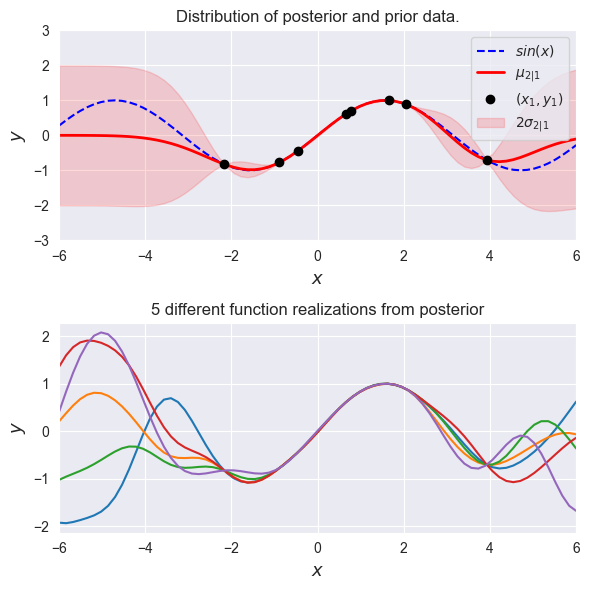

In [17]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6), dpi=100)
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

### Noisy observations

The predictions made above assume that the observations $f(X_1) = \mathbf{y}_1$ come from a noiseless distribution. We can notice this in the plot above because the posterior variance becomes zero at the observations $(X_1,\mathbf{y}_1)$.
We can make predictions from noisy observations $f(X_1) = \mathbf{y}_1 + \epsilon$, by modelling the noise $\epsilon$ as Gaussian noise with variance $\sigma_\epsilon^2$.

This noise can be modelled by adding it to the covariance kernel of our observations:

$$
\Sigma_{11} = k(X_1,X_1) + \sigma_\epsilon^2 I
$$

Where $I$ is the identity matrix. Note that the noise only changes kernel values on the diagonal (white noise is independently distributed). The Gaussian process posterior with noisy observations is implemented in the `GP_noise` method below.

In [18]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, σ_noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((σ_noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

The code below calculates the posterior distribution of the previous 8 samples with added noise. Note in the plots that the variance $\sigma_{2|1}^2$ at the observations is no longer 0, and that the functions sampled don't necessarily have to go through these observational points anymore.

In [19]:
# Compute the posterior mean and covariance

σ_noise = 0.2  # The standard deviation of the noise
# Add noise kernel to the samples we sampled previously
y1 = y1 + ((σ_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, exponentiated_quadratic, σ_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

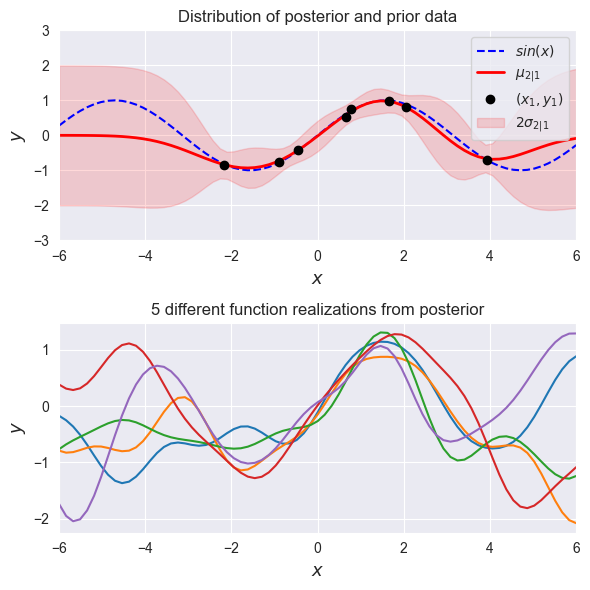

In [20]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6,6), dpi=100)
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

To conclude we've implemented a Gaussian process and illustrated how to make predictions using it's posterior distribution.

Key points to take away are:
* A Gaussian process is a distribution over functions fully specified by a mean and covariance function.
* Every finite set of the Gaussian process distribution is a multivariate Gaussian.
* The posterior predictions of a Gaussian process are weighted averages of the observed data where the weighting is based on the coveriance and mean functions.

You can read how to fit a Gaussian process kernel in the follow up post.

## Sidenotes

1. Observe in the plot of the 41D Gaussian marginal from the exponentiated quadratic prior that the functions drawn from the Gaussian process distribution can be non-linear. The non-linearity is because the kernel can be interpreted as implicitly computing the inner product in a different space than the original input space (e.g. a higher dimensional feature space). This is what is commonly known as the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick).
2. $\Sigma_{11}^{-1} \Sigma_{12}$ can be computed with the help of Scipy's [`solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) function, which solves for $x$ the [linear system](https://en.wikipedia.org/wiki/System_of_linear_equations) $\Sigma_{11} \cdot x = \Sigma_{12}$. Using this method [improves](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/) the speed and numerical accuracy compared to computing the inverse of $\Sigma_{11}$ directly. Especially since it can make use of the fact that $\Sigma_{11}$ is [symmetric and positive definite](https://en.wikipedia.org/wiki/Cholesky_decomposition#Applications).

## References

1. [Introduction to Gaussian processes videolecture](https://www.youtube.com/watch?v=4vGiHC35j9s&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=8) by Nando de Freitas.
2. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) by Carl Edward Rasmussen and Christopher K. I. Williams (Book covering Gaussian processes in detail, online version downloadable as pdf).
3. [Stochastic Processes and Applications](http://wwwf.imperial.ac.uk/~pavl/PavliotisBook.pdf) by Grigorios A. Pavliotis.



In [21]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(scipy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.7.6
numpy: 1.18.1
scipy: 1.4.1
matplotlib: 3.3.4
seaborn: 0.10.0
